# Проект - telecom_5

## Задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

### Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Данные также находятся в тренажёре, в папке /datasets/

RANDOM_STATE = 220523, это будет наше значение random_state на протяжении всего проекта!

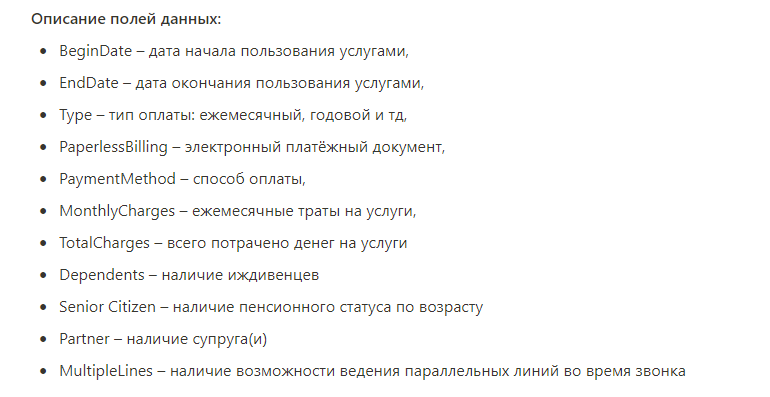

### Задача 

  Перед нами стоит задача  бинарной классификации(ушел/не ушел), метрика у нас AUC-ROC>0.85

Бизнес-метрика здесь — это убытки по двум направлениям: 

  -  пользователю предложили промокоды, но он не собирался уходить (false positive), 
  
  -  пользователю ничего не предложили и он ушёл (false negative).
    
Так как величина промокода пока неизвестна, используйте метрику, которая учитывает возможность балансировать между этими (false posititve и false negative) — AUC-ROC. В качестве дополнительной метрики так же вычислите accuracy

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! Название и описание на месте! </div>
    <br>

# Выполнение проекта 

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

## Предварительный анализ

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from numpy.random import RandomState
from tqdm import notebook
import re

### Загрузим

In [3]:
import os

path1_1 = "/content/drive/MyDrive/Colab Notebooks/contract_new.csv"
path1_2 = "/content/drive/MyDrive/Colab Notebooks/personal_new.csv"
path1_3 = "/content/drive/MyDrive/Colab Notebooks/internet_new.csv"
path1_4 = "/content/drive/MyDrive/Colab Notebooks/phone_new.csv"

path2_1 = "/datasets/contract_new.csv"
path2_2 = "/datasets/personal_new.csv"
path2_3 = "/datasets/internet_new.csv"
path2_4 = "/datasets/phone_new.csv"


In [4]:
if os.path.exists(path1_1):
    contract = pd.read_csv(path1_1, index_col=['customerID'], parse_dates=['BeginDate', 'EndDate'])  
    personal = pd.read_csv(path1_2, index_col=['customerID'])
    internet = pd.read_csv(path1_3, index_col=['customerID'])
    phone = pd.read_csv(path1_4, index_col=['customerID'])
elif os.path.exists(path2_1):
    contract = pd.read_csv(path2_1, index_col=['customerID'], parse_dates=['BeginDate', 'EndDate'])  
    personal = pd.read_csv(path2_2, index_col=['customerID'])
    internet = pd.read_csv(path2_3, index_col=['customerID'])
    phone = pd.read_csv(path2_4, index_col=['customerID'])

### Посмотрим

In [5]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [6]:
get_data_info(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
9060-HJJRW,2015-11-01,No,One year,Yes,Credit card (automatic),56.40,3106.51
2737-YNGYW,2019-11-01,No,Month-to-month,No,Electronic check,80.55,260.98
1241-EZFMJ,2015-01-01,No,Two year,No,Bank transfer (automatic),25.45,1676.65
7184-LRUUR,2018-04-01,No,One year,No,Bank transfer (automatic),65.25,1535.99
3315-IKYZQ,2017-10-01,No,One year,No,Mailed check,50.80,1422.4


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


None

/tmp/ipykernel_63/3612899437.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,67,3,2,4,NaN,6658
top,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5942,3875,4171,2365,NaN,11
first,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN


In [7]:
print('Дата начала датасета: ', min(contract['BeginDate']))
print('Дата конца датасета: ', max(contract['BeginDate']))

Дата начала датасета:  2013-10-01 00:00:00
Дата конца датасета:  2020-02-01 00:00:00


In [8]:
get_data_info(personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
3244-CQPHU,Female,1,No,No
6365-HITVU,Female,0,Yes,Yes
4280-DLSHD,Male,0,Yes,No
6997-UVGOX,Male,0,Yes,Yes
0520-FDVVT,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN


In [9]:
get_data_info(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
3055-VTCGS,DSL,No,No,Yes,No,No,Yes
2193-SFWQW,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
5062-CJJKH,DSL,No,Yes,Yes,No,No,No
5306-BVTKJ,DSL,No,Yes,Yes,No,No,No
0020-INWCK,Fiber optic,No,Yes,Yes,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


In [10]:
get_data_info(phone)

,MultipleLines
customerID,
3070-DVEYC,Yes
2251-PYLPB,Yes
6051-PTVNS,No
1907-UBQFC,No
7594-RQHXR,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None

,MultipleLines
count,6361
unique,2
top,No
freq,3390


### Добавим столбцы 

Будем работать с копией основного файла contract

In [11]:
df = contract.copy()

Заполним пропуски  нулями в  TotalCharges и изменим тип данных 

In [12]:
df.loc[contract['TotalCharges'] == " ", 'TotalCharges'] = 0
df['TotalCharges'] = df['TotalCharges'].astype(float)

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Хорошо! </div>
    <br>

Добавм столбец Goal  с целевым  признаком клиент ушел или действующий 

In [13]:
df['Goal'] = (df['EndDate'] != 'No').astype(int)  #Целевой признак - если дата окончания контракта не заполнена, значит клиент действующий

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! Целевой признак определен!</div>

Добавим столбец с подсчетом дней действия контракта 

In [14]:
df['EndDate'] = df['EndDate'].where(df['EndDate'] != 'No', '2020-02-01')
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['TotalDays'] = (df['EndDate'] - df['BeginDate']).dt.days  #дней действия контракта

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отличный признак! </div>

Добавим столбцы идентификаторы, какими услугами пользуется клиент

In [15]:
internet['Internet'] = 'Yes'                          #идентификатор о пользовании услугой "интернет" в будущем объединенном файле
phone['Phone'] = 'Yes'                                #идентификатор о пользовании услугой "телефон" в будущем объединенном файле

### Объединим данные в один датасет

In [16]:
df = df.join(personal)
df = df.join(internet)
df = df.join(phone)

df = df.fillna('NoInfo') #заполним пропуски заглушками 

In [17]:
get_data_info(df)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Goal,TotalDays,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
0620-DLSLK,2019-01-01,2020-02-01,Month-to-month,Yes,Mailed check,81.90,1064.70,0,396,Female,...,Fiber optic,No,No,No,No,Yes,No,Yes,No,Yes
1373-ORVIZ,2019-01-01,2020-02-01,Month-to-month,Yes,Electronic check,66.35,888.43,0,396,Female,...,DSL,No,No,No,Yes,No,Yes,Yes,Yes,Yes
2657-ALMWY,2017-08-01,2020-02-01,Month-to-month,No,Electronic check,84.95,2548.50,0,914,Female,...,Fiber optic,No,Yes,No,No,No,Yes,Yes,No,Yes
3186-AJIEK,2014-08-01,2020-02-01,Two year,Yes,Bank transfer (automatic),105.65,7251.82,0,2010,Male,...,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes
5512-IDZEI,2016-04-01,2020-02-01,One year,No,Electronic check,24.90,1168.31,0,1401,Male,...,NoInfo,NoInfo,NoInfo,NoInfo,NoInfo,NoInfo,NoInfo,NoInfo,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Goal              7043 non-null   int64         
 8   TotalDays         7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

None

/tmp/ipykernel_63/3612899437.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))
/tmp/ipykernel_63/3612899437.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Goal,TotalDays,gender,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Internet,MultipleLines,Phone
count,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043,...,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,77,67,3,2,4,NaN,NaN,NaN,NaN,2,...,3,3,3,3,3,3,3,2,3,2
top,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Male,...,Fiber optic,No,No,No,No,No,No,Yes,No,Yes
freq,366,5942,3875,4171,2365,NaN,NaN,NaN,NaN,3555,...,3096,3498,3088,3095,3473,2810,2785,5517,3390,6361
first,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,2115.312885,0.156325,898.555729,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,2112.742814,0.363189,683.130510,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,0.000000,276.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Хорошо! Данные объединены корректно! </div>

### Визуализация 

Посмотрим на гистограммы распределения числовых значений в объединенном  датасете

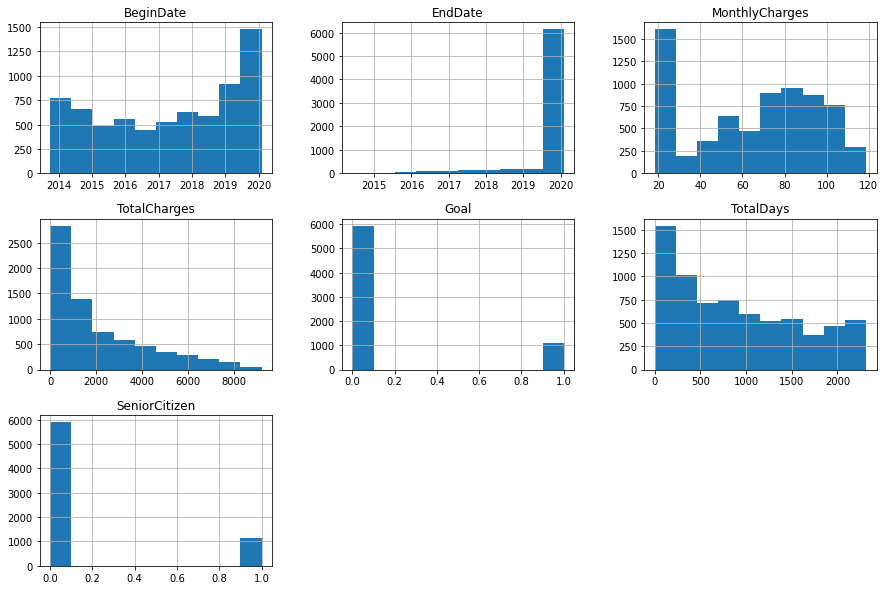

In [18]:
df.hist(figsize=(15, 10))
plt.show()

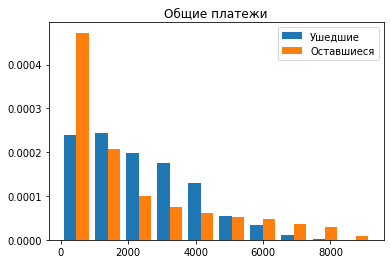

In [19]:
plt.hist([df[df.Goal == 1].TotalCharges, df[df.Goal == 0].TotalCharges], label=['Ушедшие', 'Оставшиеся'], density=True);
plt.legend();
plt.title('Общие платежи');
plt.show();

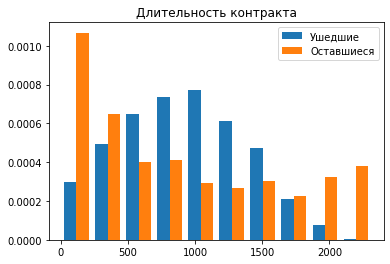

In [20]:
plt.hist([df[df.Goal == 1].TotalDays, df[df.Goal == 0].TotalDays], label=['Ушедшие', 'Оставшиеся'], density=True);
plt.legend();
plt.title('Длительность контракта');
plt.show();

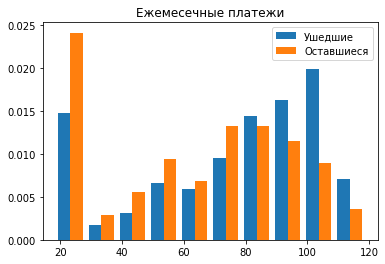

In [21]:
plt.hist([df[df.Goal == 1].MonthlyCharges, df[df.Goal == 0].MonthlyCharges], label=['Ушедшие', 'Оставшиеся'], density=True);
plt.legend();
plt.title('Ежемесечные платежи');
plt.show();

Text(0.5, 1.0, 'Метод оплаты')

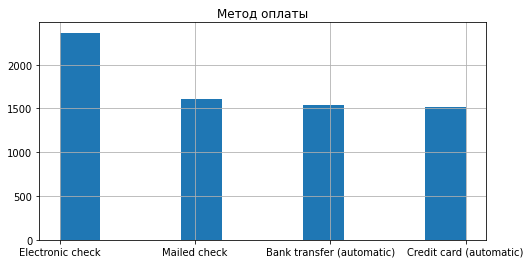

In [22]:
df['PaymentMethod'].hist(figsize=(8,4))
plt.title('Метод оплаты')

Text(0.5, 1.0, 'Пол контрагента')

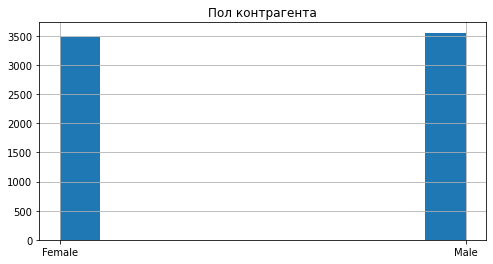

In [23]:
df['gender'].hist(figsize=(8,4))
plt.title('Пол контрагента')

Text(0.5, 1.0, 'Пенсионный статус')

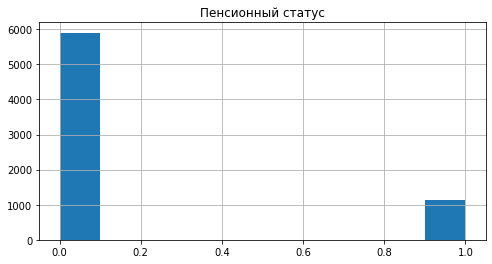

In [24]:
df['SeniorCitizen'].hist(figsize=(8,4))
plt.title('Пенсионный статус')

Text(0.5, 1.0, 'Тип платежей')

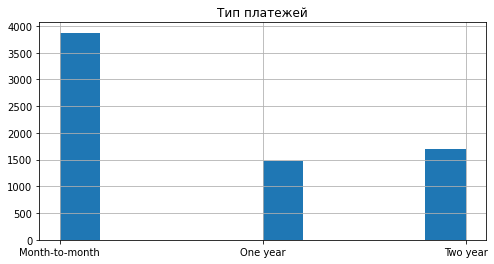

In [25]:
df['Type'].hist(figsize=(8,4))
plt.title('Тип платежей')

### Мультиколлинеарность

Посмотрим на корреляцию числовых признаков в  объединенном датасете 

(На важность не чиcловых признаков сможем посмотреть после кодирования признаков)

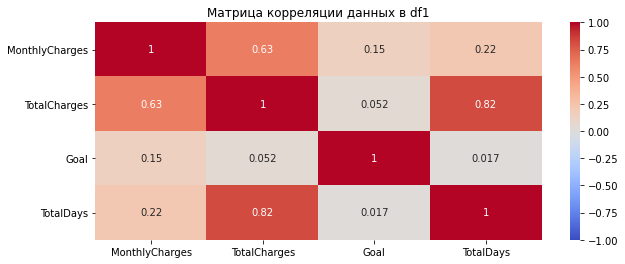

In [26]:
plt.figure(figsize = (10,4))
df1 = df.drop(['SeniorCitizen'], axis = 1 )
sns.heatmap(df1.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title('Матрица корреляции данных в df1')
plt.show()

In [27]:
!pip install phik
from phik import report
from phik.report import plot_correlation_matrix

     |████████████████████████████████| 686 kB 2.4 MB/s eta 0:00:01


In [28]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Goal', 'TotalDays', 'SeniorCitizen']


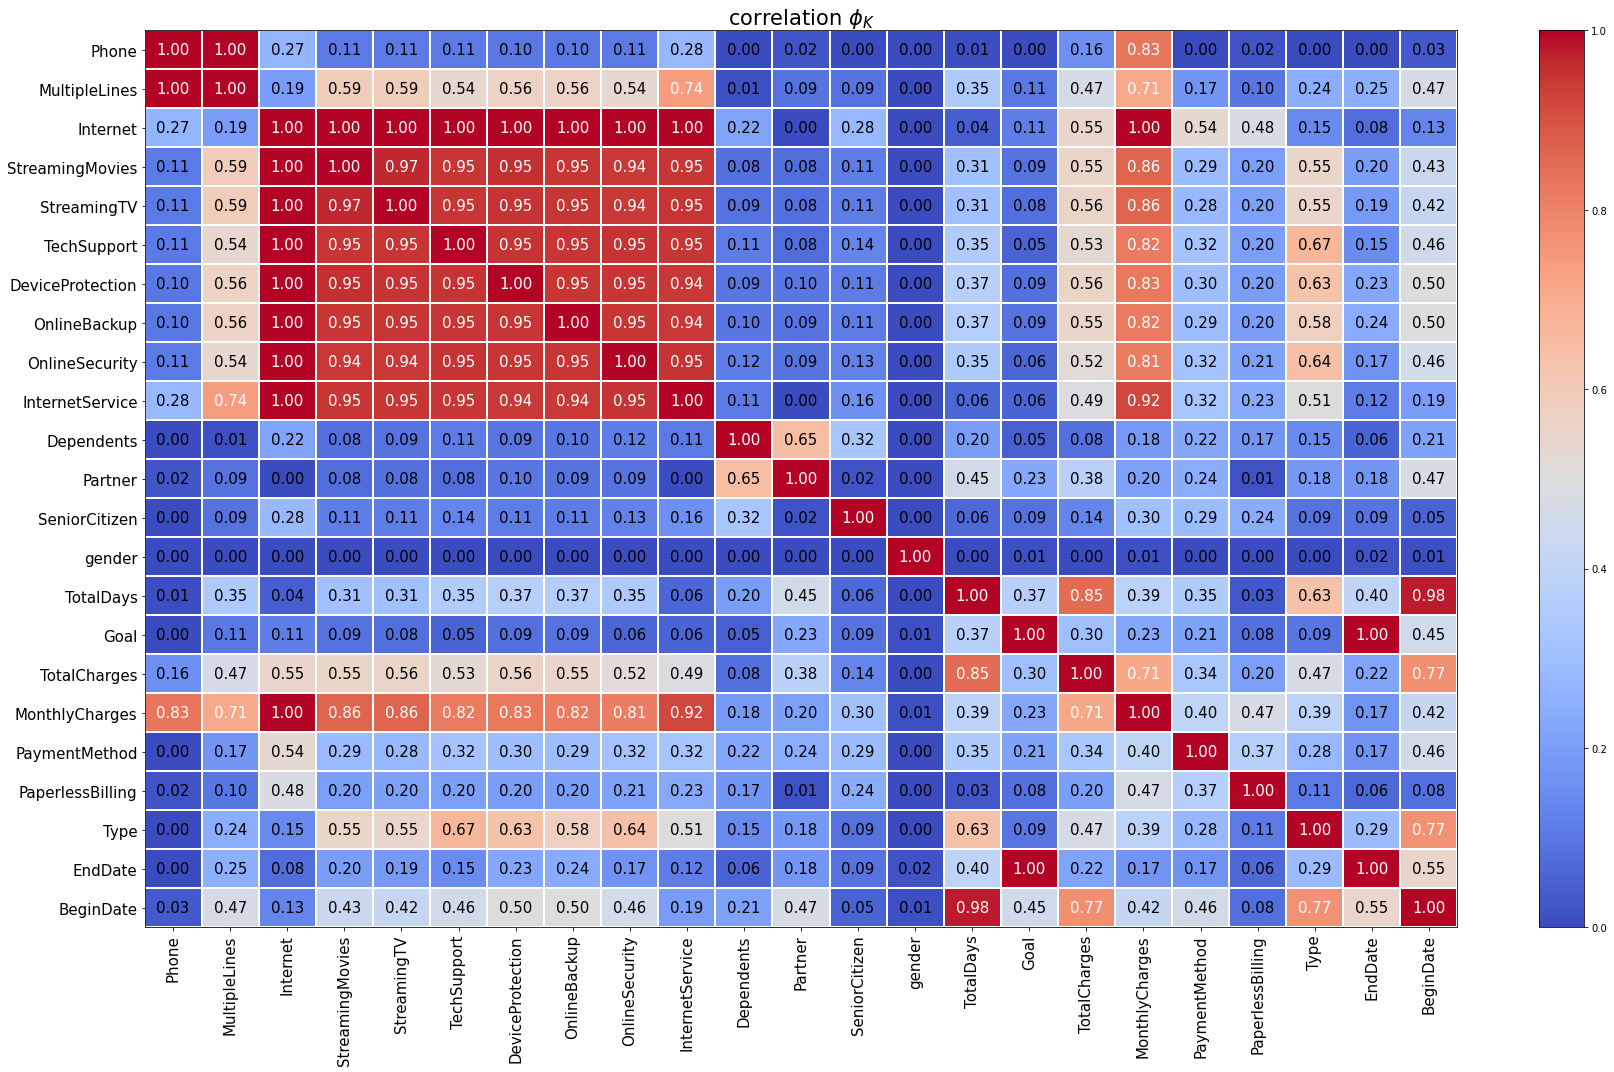

In [29]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(25, 15))
plt.tight_layout()

<div class="alert alert-info"> <b>Комментарий студента 3 :</b> пробовала phik. получилось красиво.   </div>

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

По данной матрице видно что наибольшая корреляций у целевого столбца наблюается с: 
  * Продолжительностью действия договора 
  * Суммой ежемесячныз платежей
  * Общей Суммой платежей по договору 

### Вывод по итогам предварительного анализа: 

 - В  объединенный датасет  вошло около 7 тыс строк,
 - Из данных полученных в предварительном анализе  мы видем что  контракты примерно поровну заключены с мужчинами и женщинами,
 - Большинство контрагентов платят  ежемесячно, 
 - Клиентов пользующихмя услугами телефонии немного больше чем интернетом
 - Среди клиентов с суммой ежемесячного платежа больше 80 количество "ушедших" больше чем "оставшихся" значит стоимость услуг один из ключевых факторов влияющих на решение уйти 
 - В методах обплаты преобладает электронный чек,  остальные три метода популярны практически в равной мере 
 - При длительности контракта более 500 дней (примерно) колчество "ушедших" пользователей становится больше чем "оставшихся". Возможно где-то после 1,5 лет у пользователей заканчиваются какие то выгодные ему условия обслуживания в результате чего клиент предпочитает уйти.

## Подготовка данных к обучению 

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

!pip install catboost
from catboost import CatBoost, CatBoostClassifier, Pool

### Разбиение данных на выборки : train= 0,75 , test = 0,25

Удалим колонки с датами 

In [31]:
df_teach = df.drop(['BeginDate', 'EndDate'], axis=1)

Обозначим целевой признак 
и зададим переменную рандом

In [32]:
RANDOM_STATE = 220523

X = df_teach.drop(['Goal'], axis = 1 )
y = df_teach['Goal']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [34]:
X_train.shape, X_test.shape

((5282, 20), (1761, 20))

### Кодирование для LogisticRegression

In [35]:
X_train_lr = pd.get_dummies(X_train,drop_first=True)

In [36]:
X_train_lr.shape, X_train.shape

((5282, 31), (5282, 20))

In [37]:
X_train_lr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2205-LPVGL to 5375-XLDOF
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5282 non-null   float64
 1   TotalCharges                           5282 non-null   float64
 2   TotalDays                              5282 non-null   int64  
 3   SeniorCitizen                          5282 non-null   int64  
 4   Type_One year                          5282 non-null   uint8  
 5   Type_Two year                          5282 non-null   uint8  
 6   PaperlessBilling_Yes                   5282 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  5282 non-null   uint8  
 8   PaymentMethod_Electronic check         5282 non-null   uint8  
 9   PaymentMethod_Mailed check             5282 non-null   uint8  
 10  gender_Male                            5282 non-null   uint8  

### Cписок для кодирования бустинговых

In [38]:
LIST_FOR_CODING=["Type",
                 "PaperlessBilling",
                 "PaymentMethod",
                 "gender",
                 "Partner",
                 "Dependents", 
                 "InternetService", 
                 "OnlineSecurity", 
                 "OnlineBackup", 
                 "DeviceProtection", 
                 "TechSupport",
                 "StreamingTV",
                 "StreamingMovies",
                 "Internet",
                 "MultipleLines",
                 "Phone"]

### Масштабируем признаки методом стандартизации (StandardScaler)

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
scaler = StandardScaler()
scaler.fit(X_train[numeric_columns])

X_train = X_train.copy()
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])

X_test = X_test.copy()
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Молодец, что кодируешь и масштабируешь после разбиения выборки</div>

##  Обучение моделей 

###  Модель №1 - LogisticRegression

In [41]:
%%time
lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
param_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
search_lr = GridSearchCV(lr, param_lr, cv=5, scoring='roc_auc')
search_lr.fit(X_train_lr, y_train)

print('best_params_', search_lr.best_params_)
print('ROC-AUC: ', search_lr.best_score_)

best_params_ {'C': 0.1}
ROC-AUC:  0.7559846965478587
CPU times: user 3.87 s, sys: 3.12 s, total: 6.99 s
Wall time: 6.98 s


<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично!</div>

### Модель №2 - CatBoostClassifier

In [42]:
!pip install catboost
from catboost import CatBoostClassifier

In [43]:
%%time
cat  = CatBoostClassifier(random_state = RANDOM_STATE)
param_cat = {'learning_rate': [0.1, 0.3], 'iterations': [50, 100], 'l2_leaf_reg': [3, 9]}
search_cat = GridSearchCV(cat, param_cat, cv=5, scoring='roc_auc')
search_cat.fit(X_train, y_train, cat_features=LIST_FOR_CODING)

print('best_params_', search_cat.best_params_)
print('ROC-AUC: ', search_cat.best_score_)

0:	learn: 0.6158746	total: 56.2ms	remaining: 2.75s
1:	learn: 0.5610855	total: 63.1ms	remaining: 1.51s
2:	learn: 0.5224885	total: 68.9ms	remaining: 1.08s
3:	learn: 0.4933068	total: 75.3ms	remaining: 866ms
4:	learn: 0.4678989	total: 81.1ms	remaining: 730ms
5:	learn: 0.4472583	total: 86.7ms	remaining: 636ms
6:	learn: 0.4314600	total: 92.6ms	remaining: 569ms
7:	learn: 0.4198274	total: 98.4ms	remaining: 517ms
8:	learn: 0.4090552	total: 104ms	remaining: 475ms
9:	learn: 0.4005084	total: 110ms	remaining: 441ms
10:	learn: 0.3943052	total: 116ms	remaining: 412ms
11:	learn: 0.3835420	total: 121ms	remaining: 384ms
12:	learn: 0.3764244	total: 127ms	remaining: 362ms
13:	learn: 0.3685832	total: 133ms	remaining: 342ms
14:	learn: 0.3629195	total: 139ms	remaining: 324ms
15:	learn: 0.3577467	total: 145ms	remaining: 308ms
16:	learn: 0.3542915	total: 151ms	remaining: 293ms
17:	learn: 0.3514298	total: 157ms	remaining: 278ms
18:	learn: 0.3479760	total: 162ms	remaining: 265ms
19:	learn: 0.3438919	total: 168ms

### Модель №3 - LGBMClassifier

In [44]:
from lightgbm import LGBMClassifier

In [45]:
X_train_light = X_train.copy()
X_train_light = X_train_light.astype({"Type":'category',
                                      "PaperlessBilling":'category',
                                      "PaymentMethod":'category',
                                      "gender":'category',
                                      "Partner":'category',
                                      "Dependents":'category', 
                                      "InternetService":'category', 
                                      "OnlineSecurity":'category', 
                                      "OnlineBackup":'category', 
                                      "DeviceProtection":'category', 
                                      "TechSupport":'category',
                                      "StreamingTV":'category',
                                      "StreamingMovies":'category',
                                      "Internet":'category',
                                      "MultipleLines":'category',
                                      "Phone":'category'})

In [46]:
X_test_light = X_test.copy()
X_test_light = X_test_light.astype({"Type":'category',
                                      "PaperlessBilling":'category',
                                      "PaymentMethod":'category',
                                      "gender":'category',
                                      "Partner":'category',
                                      "Dependents":'category', 
                                      "InternetService":'category', 
                                      "OnlineSecurity":'category', 
                                      "OnlineBackup":'category', 
                                      "DeviceProtection":'category', 
                                      "TechSupport":'category',
                                      "StreamingTV":'category',
                                      "StreamingMovies":'category',
                                      "Internet":'category',
                                      "MultipleLines":'category',
                                      "Phone":'category'})

In [47]:
%%time
model_gb = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
param_gb = {'n_estimators': [300, 500, 1000], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 5, 9], 'num_threads':[1]}
search_gb = GridSearchCV(model_gb, param_gb, cv=5, scoring='roc_auc')
search_gb.fit(X_train_light, y_train)

print('best_params_', search_gb.best_params_)
print('ROC-AUC: ', search_gb.best_score_)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

## Проверка лучшей модели на тестовой выборке 

In [48]:
%%time
print('roc_auc_test=', roc_auc_score(y_test, search_gb.predict_proba(X_test_light)[:, 1]).round(2))

roc_auc_test= 0.92
CPU times: user 72.9 ms, sys: 17 µs, total: 72.9 ms
Wall time: 70.1 ms


<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>

### Матрица ошибок

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
predicted_test = search_gb.predict(X_test_light)

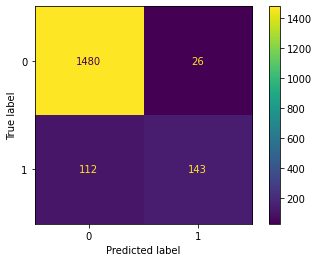

In [51]:
cm = confusion_matrix(y_test, predicted_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show();

Видим что модель хорошо предсказала значение О, а вот  в предсказании значения 1 ошибок намного больше 

### ROC-AUC кривая

AUC-ROC:  0.921


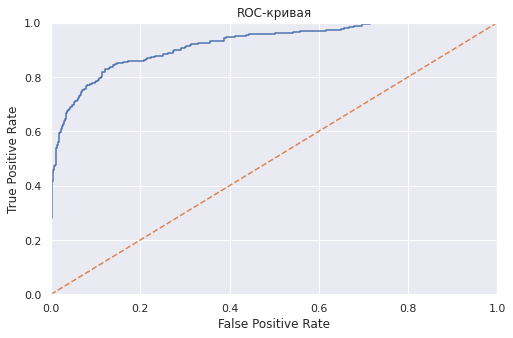

In [52]:
pred_proba_test = search_gb.predict_proba(X_test_light)[:, 1]
pred_test = search_gb.predict(X_test_light)
print('AUC-ROC: ', round(roc_auc_score(y_test, pred_proba_test), 3))
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)

sns.set()
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

###  Визуализация важности признаков

In [53]:
best_model_gb = search_gb.best_estimator_

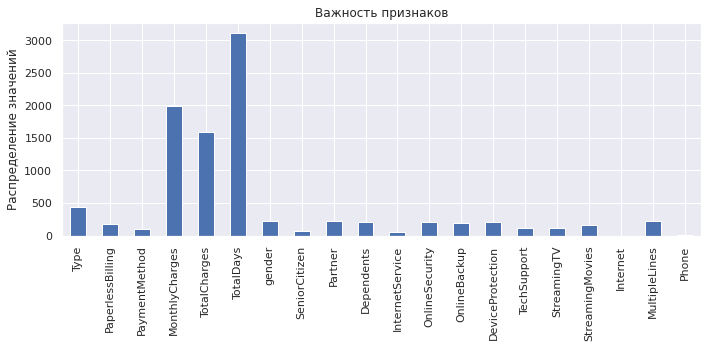

In [54]:
importances = best_model_gb.feature_importances_
X_importances = pd.Series(importances, index= X_test_light.columns)

fig, ax = plt.subplots()
X_importances.plot.bar(figsize=(10, 5))
ax.set_title("Важность признаков")
ax.set_ylabel("Распределение значений")
fig.tight_layout()

# Выводы 

* В данной работе проведена работа по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет

* Сначала данные были прочитаны и рассмотренв

* После этого была произведена первичная обработка данных - переименованы столбцы, изменены типы данных 

* Были добавлены 2 новых столбца - целевой признак `Goal`, который означает отказался ли клиент от услуг и `TotalDays`, который обозначает сколько по времени пользователь пользовался услугами

* После этого был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком

* Были сделаны следующие выводы: Чем дольше клиент пользуется услугами тем меньше вероятность что он сменит оператора, при условии что ежемесячная плата его устраивает

* После этого была проведена подготовка данных к обучению моделей

* Затем на данных были обучены 3 модели: 
    * LogisticRegression, 
    * CatBoostClassifier,
    * LGBMClassifier
* Лучший результат показала модель LGBMClassifier со значением метрики ROC-AUC в 0.92 на тестовой выборке 

* Анализ важности признаков признаков подтвердил что самые важные признаки : 
    * сколько клиент пользуется услугами и 
    * сколько он платит в месяц
    * общая сумма расходов 

# В отчёте ответьте на вопросы:

* **Какие пункты плана были выполнены, а какие — нет. Почему?**
  
  План был сделан после первого вэбинара с тимлидом, поэтому изначально был довольно близок к итоговой структуре проекта. Были выполнены все шаги запланированные по плану.

* **Какие трудности возникли и как вы их преодолели?**
  
  Трудности были в части исполнения кода, нужного для исполнения некоторых пунктов: 
    * в использовании новых библиотек 
    * в Использовании новых,   для меня, функций в ранее используемых быблиотеках.

  Преодолевала трудности:
    * Методом эксперимента 
    * Ища похожие примеры в сети и читая документацию
    * Обсуждая/советуясь с коллегами-одногруппниками
    * C помощью тимлида

* **Какие ключевые шаги в решении задачи вы выделили?**
  
  Ключевые шаги: 
    * Распаковать/посмотреть имеющиеся данные
    * Оценить корректность иполноту данных - провести предобработку
    * Сделать первые выводы об изученных данных , исходя из этого подобрать модели для обучения
    * Подготовить данные к обучению исходя из требования выбранных моделей 
    * Обучить модели и выбрать лучшую
    * Проверить лучшую модель на тестовой выборке 
    * Сделать выводы о результатах обучения модели 

* **Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?**
  
  Для обучения модели использовались все признаки которые были в исходных данных, исключая Даты начала и окончания договора. А также были добавлены в процессе предобработки: 
    * Goal - целевой признак 
    * TotalDays - подолжительность договора в днях 
    * Phone & Internet - услуги используемые по догвоору 

  В процессе предобработки:  
    * были обработаны пропущенные значения
    * Добавлены выше указанные  новые признаки 
    * Данные из нескольких источников были объединены в один датасет 
    * Рассмотрена мультиколлинеарность признаков 
    * Удалены признаки Дат  договора 

* **Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?** 
  
  Лучшей моделью из выбранных для проекта оказалась LGBMClassifier со значением метрики ROC-AUC  0.92 на тестовой выборке. 
  
  Гиперпараметры лучшей модели LGBMClassifier: 
    * 'learning_rate': 0.1, 
    * 'max_depth': 5, 
    * 'n_estimators': 500, 
    * 'num_threads': 1


<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;background:rgb(185, 176, 207)">
<b>Итоговый комментарий ревьюера:
</b>Да! Все хорошо!
</div>